In [1]:
import pandas as pd
import json
import re
from os.path import join
from collections import Counter
from tqdm import tqdm

import networkx as nx
from networkx.algorithms import community 

def clean_title(title):
    title = re.sub(r'\s+',' ',title)
    title = re.sub(r'<\/b>','',title)
    title = re.sub(r',','',title)
    return title

In [2]:
path = join('..','Export','Export_leiden_prayer_20250218131307.json')
json_file = open(path)
json_data = json.load(json_file)
records = json_data['heurist']['records']

In [3]:
rec_type_names = dict()
database = json_data['heurist']['database']

for rec_type_id in database['rectypes']:
    rec_type = database['rectypes'][rec_type_id]
    code = rec_type['code'] 
    code = code[code.index('-')+1:]
    rec_type_names[ code ] = rec_type['name']
    
for rec_type in rec_type_names:
    print(f'{rec_type} - {rec_type_names[rec_type]}')

102 - Production layer
112 - Expression
134 - Stamp
137 - Reference
123 - Text
1 - Record relationship
105 - Decoration
129 - Binding
10 - Person
125 - Centre
117 - Keyword
118 - Literature
111 - Edition
1009 - Historical Localisation
104 - Institution
127 - Present-day Location
135 - Nature
132 - Expression Edition
24 - Life event
52 - CMS Menu-Page
133 - Decoration Edition
136 - Iconclass


## Make the titles

In [4]:
titles = dict()
for record in records:
    
    # Text
    if record['rec_RecTypeID'] == '123':
        H_ID = record['rec_ID']
        for field in record['details']:
            if field['dty_ID']==1152:
                title = field['value']
                titles[H_ID] = title
                
    # Production Layer
    if record['rec_RecTypeID'] == '102':
        H_ID = record['rec_ID']
        for field in record['details']:
            if field['dty_ID']==1098:
                title = field['value']
                title = re.sub('\'S-GRAVENHAGE, KB\s*','KB NL',title)
                title = re.sub('BRUSSEL, KB\s*','KB BE',title)
                title = re.sub('KOPENHAGEN, KB\s*','KB DE',title)
                title = re.sub('LEIDEN, UB\s*','UBL',title)
                title = re.sub('LONDEN, BL\s*','BL',title)
                title = re.sub('PARIJS, BN\s*','BNF',title)
                
                titles[H_ID] = title

                


## Creates nodes and edges file

In [5]:
nodes_file = open('nodes1.csv','w',encoding='utf-8')
edges_file = open('edges1.csv','w',encoding='utf-8')

nodes_file.write('Id,Label,Type\n')
edges_file.write('Source,Target,Direction\n')

direction = 'Undirected'

nodes = []
edges = []



for record in records:
    
    # Expression
    if record['rec_RecTypeID'] == '112':
       
        container_HID=''
        text_HID=''
        for field in record['details']:

            if field['dty_ID']==1193:
                # Text
                text_HID = field['value']['id']
                nodes.append( (text_HID,'Text') )

        
            if field['dty_ID']==1274:
                # Production Layer
                container_HID = field['value']['id']
                nodes.append((container_HID,'Book'))
                
        if re.search('\d+',str(container_HID)) and re.search('\d+',text_HID):
            edges_file.write(f'{container_HID},{text_HID},{direction}\n')
            # Edges are collected for networkX
            edges.append( (container_HID,text_HID) )
                
edges_file.close()

nodes = list(set(nodes))
for node in nodes:
    nodes_file.write(f'{node[0]},"{titles[node[0]]}",{node[1]}\n')
nodes_file.close()

## Co-transmission

In [6]:

G = nx.Graph()

for node in nodes:
    G.add_node( node[0] , type = node[1] )
                
for edge in edges:
    G.add_edge( edge[0] , edge[1] )


In [7]:
print(nx.info(G))
node_type = nx.get_node_attributes(G, 'type')

Graph with 1872 nodes and 4692 edges


In [8]:
all_nodes = G.nodes()

co_occurring = []

for node1 in tqdm(all_nodes):

    if node_type[node1] == 'Text': 

        for node2 in all_nodes:
            if node_type[node2] == 'Text' and node1 != node2:
                
                paths = nx.all_simple_paths( G,source=node1,target=node2,cutoff=3)
                for path in map(nx.utils.pairwise, paths):
                    path_nodes = list(path)
                    n1 = path_nodes[0][0]
                    n2 = path_nodes[0][1]
                    n3 = path_nodes[1][1]
                    co_occurring.append( (n1,n2,n3) )



100%|███████████████████████████████████████| 1872/1872 [13:34<00:00,  2.30it/s]


In [9]:
## Example

nodes_file = open('nodes3.csv','w',encoding='utf-8')
edges_file = open('edges3.csv','w',encoding='utf-8')

nodes_file.write('Id,Label,Type\n')
edges_file.write('Source,Target,Direction\n')

direction = 'Undirected'

nodes = []
edges = []


for source,book,target in co_occurring:
    

    edges.append( (source,book) )
    edges.append( (target,book) )

    if source not in nodes:
        nodes.append( (source,'Text') )
    if target not in nodes:
        nodes.append( (target,'Text') )
    if book not in nodes:
        nodes.append( (book,'Book') )
    
for e in edges:
    edges_file.write(f'{e[0]},{e[1]},"Undirected"\n')
    
nodes = list(set(nodes))
    
for n in nodes:
    nodes_file.write(f'{n[0]},"{titles[n[0]]}","{n[1]}"\n')
    
edges_file.close()
nodes_file.close()

## Cooccurrence

In [10]:
nodes_file = open('nodes2.csv','w',encoding='utf-8')
edges_file = open('edges2.csv','w',encoding='utf-8')

nodes_file.write('Id,Label,Type\n')
edges_file.write('Source,Target,Type\n')

direction = 'Undirected'

nodes = []

clusters = []
for source,book,target in co_occurring:
    clusters.append( (source,target) )
    
       
for source,book,target in co_occurring:
    edges_file.write(f'{source},{target},{direction}\n')
    if source not in nodes: 
        nodes.append(source)
    if target not in nodes: 
        nodes.append(target)
        
    
        
for node in nodes:
    nodes_file.write(f'{node},"{titles[node]}","Text"\n')
     
edges_file.close()
nodes_file.close()

## Bar Chart

In [11]:
selected = '127632'
targets = []
for source,book,target in co_occurring:
    if source == selected:
        targets.append(target)
text_freq = Counter(targets)

In [12]:
x_axis = []
y_axis = []

for text,count in text_freq.most_common(20):
    x_axis.append(text)
    y_axis.append(count)
    
x_axis = [titles[x][:20] for x in x_axis]

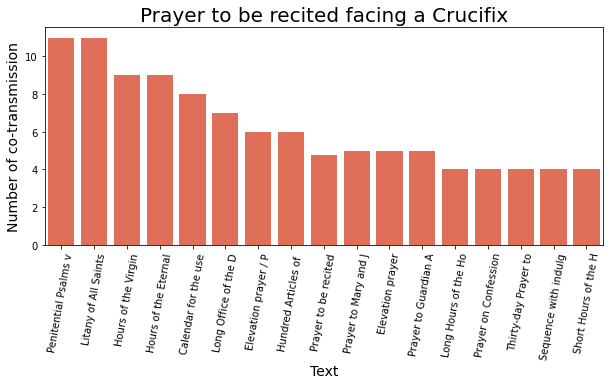

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure( figsize=( 10 , 4 ) )

graph = sns.barplot( x=x_axis, y=y_axis,
                    color = '#f56042', ci=None )

graph.set_title(titles[selected] , size = 20) 
graph.set_xlabel('Text' , size = 14) 
graph.set_ylabel('Number of co-transmission' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot


plt.show()

In [14]:
selected = '517'
targets = []
for source,book,target in co_occurring:
    if source == selected:
        targets.append(target)
text_freq = Counter(targets)

In [15]:
x_axis = []
y_axis = []

for text,count in text_freq.most_common(20):
    x_axis.append(text)
    y_axis.append(count)
    
x_axis = [titles[x][:30] for x in x_axis]

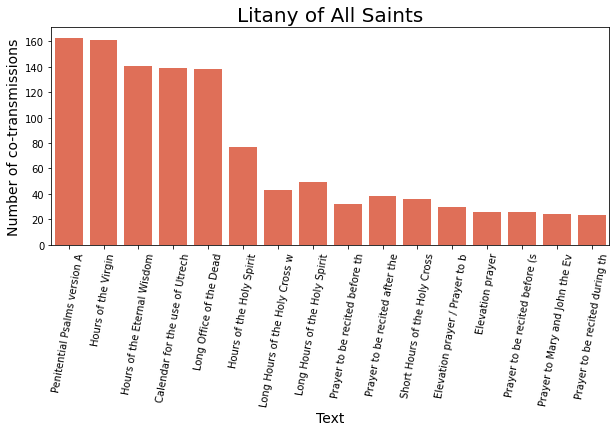

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure( figsize=( 10 , 4 ) )

graph = sns.barplot( x=x_axis, y=y_axis,
                    color = '#f56042', ci=None )

graph.set_title(titles[selected] , size = 20) 
graph.set_xlabel('Text' , size = 14) 
graph.set_ylabel('Number of co-transmissions' , size = 14 )

plt.xticks(rotation= 80)
# The next line places the legend outside out the plot


plt.show()

In [ ]:
# Identify groups of connected components (or subgraphs)
sub_graphs = nx.connected_components(G)

# Loop through all nodes in each subgraph and display them
while True:
    try:
        print(next(sub_graphs))
    except StopIteration:
        break